In [1]:
import os,sys
import pandas as pd
%matplotlib inline
os.chdir("jeme/JEME vs targetfinder/")
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals.joblib import Parallel, delayed

In [3]:
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, roc_auc_score

In [4]:
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations

In [5]:
from sklearn.externals import joblib
joblib.__version__

'0.11'

In [6]:
import sklearn
sklearn.__version__

'0.19.1'

In [6]:
train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])

In [7]:
train.loc[:,['promoter_start', 'enhancer_start']].iloc[[10,100],]

,,promoter_start,enhancer_start
enhancer_name,promoter_name,,
K562|chr10:100223000-100224600,K562|chr10:99258125-99259125,99258125,100223000
K562|chr10:102666800-102668600,K562|chr10:102106381-102107381,102106381,102666800


In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score


def aupr_auroc_f1(estimator, X, y):
    probs = estimator.predict_proba(X)
    preds = estimator.predict(X)
    aupr = average_precision_score(y, probs[:,1])
    auroc = roc_auc_score(y, probs[:,1])
    f1 = f1_score(y, preds)
    return aupr, auroc, f1


def train_an_estimator(train_data, train_label, val_data, val_label):
    estimator = GradientBoostingClassifier(**params )
    estimator.fit(train_data, train_label)
    return aupr_auroc_f1(estimator, val_data, val_label)


def train_targetfinder_cv(columns, to_shuffle):
    train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])
    
    chrom_info = {}
    keys = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    for k in keys:
        chrom_info[k] = []
    for idx in train.index:
        enhancer_tokens = idx[0].split('|')[1].replace(':', ' ').replace('-', ' ').strip().split()
        promoter_tokens = idx[1].split('|')[1].replace(':', ' ').replace('-', ' ').strip().split()
        tokens = enhancer_tokens + promoter_tokens
        for k, d in zip(keys, tokens):
            if d.isdigit():
                d = int(d)
            chrom_info[k].append(d)

    for k in keys:
        train[k] = chrom_info[k]
    train = train.sort_values(by=keys)
    train = train.drop(keys, axis=1)
    
    
    all_dists = []
    for w in train.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    train['distance'] = np.log10(all_dists)

    cv = StratifiedKFold(n_splits = 5, shuffle = to_shuffle, random_state=0)
    cv = cv.split(train.loc[:, columns], train['label'])

    tasks = []
    for train_idx, test_idx in cv:
        tasks.append(delayed(train_an_estimator)(train.iloc[train_idx,:].loc[:,columns], 
                                                 train.iloc[train_idx,:].loc[:, 'label'],
                                                 train.iloc[test_idx,:].loc[:,columns], 
                                                 train.iloc[test_idx,:].loc[:,'label']))
    
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]
    print("\nCV")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print('dummy:', np.sum(train['label'])/train.shape[0])
    


In [13]:
def train_targetfinder_intra(columns):
    train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])
    
    all_dists = []
    for w in train.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    train['distance'] = np.log10(all_dists)
    
    total_pos = np.sum(train['label'])
    total_neg = np.sum(train['label']==0)
    all_chrom_counts = {}
    
    print('counting')
    for i in train.index:
        curr_chrom = i[0].split(':')[0]+':'
    
        if curr_chrom not in all_chrom_counts:
            all_chrom_counts[curr_chrom] = [0,0]
        if train.loc[i, 'label'] == 0:
            all_chrom_counts[curr_chrom][1] += 1
        else:
            all_chrom_counts[curr_chrom][0] += 1
    all_chroms = list(all_chrom_counts.keys())
    test_chrom_combs = []
    depth = 1
    print('starting')
    while len(test_chrom_combs) < 100 and depth <= 6:
        for temp_chroms in combinations(all_chroms, depth):
            if (0.1 <= np.sum([all_chrom_counts[c][0] for c in temp_chroms]) / total_pos <= 0.12 and  
               abs(np.sum([all_chrom_counts[c][0] for c in temp_chroms])  / total_pos
                   - np.sum([all_chrom_counts[c][1] for c in temp_chroms]) / total_neg) < 0.005):
                test_chrom_combs.append(temp_chroms)

        depth += 1
        print(depth)
    np.random.seed(0)

    select_idx = np.random.choice(range(len(test_chrom_combs)), size=5, replace=False)
    print(len(test_chrom_combs), [test_chrom_combs[i] for i in select_idx])
    
    tasks = []
    dummy_avg = []
    for idx in select_idx:
        test_chroms = test_chrom_combs[idx]
        test_data = train.loc[[i for i in train.index if (i[0].split(':')[0]+':') in test_chroms], columns]
        test_labels = train['label'][test_data.index]

        train_data = train.loc[[i for i in train.index if (i[0].split(':')[0]+':') not in test_chroms], columns]
        train_labels = train['label'][train_data.index]

    
        train_data.fillna(0)
        test_data.fillna(0)
        tasks.append(delayed(train_an_estimator)(train_data, train_labels, test_data, test_labels))
        dummy_avg.append(np.sum(test_labels) / len(test_labels))
    scores = []
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]

    print("\nIntra")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print("dummpy", dummy_avg)
    #prcs, recalls, _ = precision_recall_curve(test_labels, probs[:,1])
    #plt.plot(recalls, prcs, color='blue')
    #plt.axhline(y=np.sum(test_labels) / len(test_labels), color='r')

In [9]:
def train_targetfinder(columns):
    train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])
    test = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name'])
    
    all_dists = []
    for w in train.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    train['distance'] = np.log10(all_dists)
    all_dists=[]
    for w in test.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    test['distance'] = np.log10(all_dists)


    train_data = train.loc[:, columns]
    train_labels = train['label']

    test_data = test.loc[:, columns]
    test_labels = test['label']
    train_data.fillna(0)
    test_data.fillna(0)

    estimator = GradientBoostingClassifier(**params)

    estimator.fit(train_data, train_labels)
    probs = estimator.predict_proba(test_data)
    preds = estimator.predict(test_data)
    print("\nAcross sample")
    print(average_precision_score(test_labels, probs[:,1]), 
          roc_auc_score(test_labels, probs[:,1]), 
          f1_score(test_labels, preds))
    print("dummpy", np.sum(test_labels) / len(test_labels))
    #prcs, recalls, _ = precision_recall_curve(test_labels, probs[:,1])
    #plt.plot(recalls, prcs, color='orange')
    #plt.axhline(y=np.sum(test_labels) / len(test_labels), color='r')

In [14]:
#ZNF274 (window) is present but not (enhancer) and (promoter) 
#All features
columns = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
print(len(columns))
for i in [5,10]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i}
    train_targetfinder_cv(columns, to_shuffle=True)
    train_targetfinder_cv(columns, to_shuffle=False)
    train_targetfinder_intra(columns)

408
5

CV
0.7308038004116011 0.9408767046702712 0.6520582498641387
0.004348048385922584 0.0021146738467992176 0.011882273174971715
auprcs 0.7271125024856115 0.7308070168911897 0.7391110050063726 0.7277118912170562 0.7292765864577755
aurocs 0.9423152889300553 0.9376172565505816 0.9434119725269458 0.9392982469587272 0.9417407583850461
f1s 0.6551661521699655 0.6382039013617962 0.6727598566308243 0.643459142543056 0.6507021966150522
dummy: 0.1339672541889235

CV
0.6799735888551172 0.9289139213492754 0.6125273966974829
0.012934100009117742 0.004318554634600352 0.012108279567020677
auprcs 0.6873449699956611 0.6829110085237322 0.6928526563274766 0.6553646628910326 0.6813946465376834
aurocs 0.9287277488960061 0.9302381740559792 0.9344093792339561 0.9211666165468466 0.9300276880135895
f1s 0.6179985063480209 0.6287756925826631 0.5948359541836536 0.6028318584070796 0.6181949719659975
dummy: 0.1339672541889235
counting
starting
2
3
4
5 [('K562|chr20:', 'K562|chr2:', 'K562|chr22:'), ('K562|chr7:', 

In [11]:
#ZNF274 (window) is present but not (enhancer) and (promoter) 
columns1 = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns2 = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns = list(set(columns1).intersection(columns2))
print(len(columns))
for i in [5,10]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i}
    train_targetfinder_cv(columns, to_shuffle=True)
    train_targetfinder_cv(columns, to_shuffle=False)
    train_targetfinder_intra(columns)
    train_targetfinder(columns)

208
5

CV
0.7171798815195299 0.9379231361503766 0.6420231927624529
0.005696912358058249 0.0021864813425259474 0.01008214139027451
auprcs 0.7148500343924751 0.7134254644238991 0.728531960321505 0.7145988342640902 0.71449311419568
aurocs 0.9387217152510975 0.9349658120633763 0.9414118492387115 0.9364024411722689 0.9381138630264292
f1s 0.632315053367685 0.6398977915678044 0.660882140274765 0.6346931275266446 0.6423278510753658
dummy: 0.1339672541889235

CV
0.6735425569677644 0.9269200184421603 0.6070860150865391
0.007163699640313605 0.0028053754159611277 0.012205717027863128
auprcs 0.6726871246667119 0.6750493328230662 0.6817078348458103 0.660530390859485 0.6777381016437486
aurocs 0.9251924161975644 0.9272885859745479 0.9314878231668378 0.923055405341055 0.9275758615307966
f1s 0.6146142433234422 0.6205420827389444 0.5866770549279315 0.6000727802037846 0.6135239142385926
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr20:', 'K562|chr2:', 'K562|chr22:'), ('K562|chr7:', 'K56

In [12]:
columns = ['DNase-seq (enhancer)', 'DNase-seq (promoter)', 'DNase-seq (window)', 
           'H3K27ac (enhancer)', 'H3K27ac (promoter)', 'H3K27ac (window)', 
           'H3K27me3 (enhancer)', 'H3K27me3 (promoter)', 'H3K27me3 (window)',
           'H3K4me1 (enhancer)', 'H3K4me1 (promoter)', 'H3K4me1 (window)']
for i in [5,10]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i}
    train_targetfinder_cv(columns, to_shuffle=True)
    train_targetfinder_cv(columns, to_shuffle=False)
    train_targetfinder_intra(columns)
    train_targetfinder(columns)

5

CV
0.5577195246568566 0.873271756408468 0.4543878709693733
0.007655090556403086 0.004025399183614481 0.0058083757776002404
auprcs 0.5583578967581213 0.5444026552208635 0.5682085285602214 0.5600057794486554 0.5576227632964216
aurocs 0.8728658590279635 0.8662593684567568 0.8787188525975005 0.8744406611771873 0.8740740407829316
f1s 0.454778156996587 0.4456289978678038 0.45844904934842984 0.45079501504082514 0.4622881355932204
dummy: 0.1339672541889235

CV
0.5169291887701232 0.8588323593963594 0.432726473190027
0.021214352284061436 0.006563376683563315 0.03328832690066978
auprcs 0.5000508431877934 0.5357787486274875 0.5428617761303549 0.48642058088704065 0.5195339950179395
aurocs 0.8492031756540797 0.8646598084236207 0.8666380162857887 0.8536867340555372 0.8599740625627703
f1s 0.4210749946887614 0.4669829972321075 0.37316263632053104 0.4507209164526961 0.45169082125603865
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr20:', 'K562|chr2:', 'K562|chr22:'), ('K562|chr7:', 

In [13]:
columns = ['distance']
for i in [5,10]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i}
    train_targetfinder_cv(columns, to_shuffle=True)
    train_targetfinder_cv(columns, to_shuffle=False)
    train_targetfinder_intra(columns)
    train_targetfinder(columns)
    print('\n')

5

CV
0.5280999982489228 0.8810530324324833 0.4964746941852532
0.010440997178108832 0.003937360164220902 0.0038057303573654933
auprcs 0.5340090473893422 0.525481690083131 0.5420726870393529 0.5283859813684206 0.5105505853643676
aurocs 0.8840782465901753 0.8784391042157239 0.8862012253154451 0.8751450593707863 0.8814015266702862
f1s 0.4927703875072296 0.49990445251289894 0.5009641342074816 0.49137600613261784 0.49735849056603776
dummy: 0.1339672541889235

CV
0.5256780372961086 0.8795047293772364 0.4965695999632616
0.023214875896620725 0.017592673122576397 0.014978212618236607
auprcs 0.5314322043235044 0.5366901077140226 0.5577276730751551 0.4885893615786675 0.5139508397891933
aurocs 0.8834645107529338 0.8906578711343903 0.8998099387929364 0.8482325750998212 0.8753587511061005
f1s 0.4991498205176648 0.49624927870744373 0.5176198729058348 0.4707692307692308 0.49905979691613395
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr20:', 'K562|chr2:', 'K562|chr22:'), ('K562|chr7:

In [14]:
columns1 = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns2 = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns = list(set(columns1).intersection(columns2))
columns = [i for i in columns if not'(window)' in i] + ['distance']
print(len(columns))
for i in [5,10]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i}
    train_targetfinder_cv(columns, to_shuffle=True)
    train_targetfinder_cv(columns, to_shuffle=False)
    train_targetfinder_intra(columns)
    train_targetfinder(columns)
    print('\n')

139
5

CV
0.7063318744413036 0.9386537196104955 0.6561832281726703
0.004488828179609941 0.001921925574705867 0.007093157208970658
auprcs 0.7118361007068368 0.7049536800330731 0.7114301323794855 0.7016303695931796 0.7018090894939432
aurocs 0.9410160494954569 0.9362490134175218 0.9393169603514173 0.9365442389495582 0.9401423358385231
f1s 0.653430860327412 0.6530823691935762 0.6690586024261062 0.6479847777201176 0.6573595311961393
dummy: 0.1339672541889235

CV
0.6571862371921968 0.9309329661084037 0.632328210604606
0.01176099142466198 0.004268639359323917 0.010057743087306519
auprcs 0.6524793422789352 0.6634241331522882 0.6745118342043377 0.639023625547641 0.656492250777782
aurocs 0.9303425234986008 0.93066093687829 0.9380110509310872 0.92456421033886 0.9310861088951807
f1s 0.6352661112055774 0.6409136714813571 0.637284521059179 0.612618963694043 0.6355577855828735
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr20:', 'K562|chr2:', 'K562|chr22:'), ('K562|chr7:', 'K562|chr

In [15]:
columns1 = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns2 = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns = list(set(columns1).intersection(columns2))
columns = [i for i in columns if not'(window)' in i]
print(len(columns))
for i in [5,10]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i}
    train_targetfinder_cv(columns, to_shuffle=True)
    train_targetfinder_cv(columns, to_shuffle=False)
    train_targetfinder_intra(columns)
    train_targetfinder(columns)
    print('\n')

138
5

CV
0.348091653213107 0.7822505213086594 0.07480586463553185
0.005776760126375431 0.0027548496481101725 0.007621781800450929
auprcs 0.34463884858954386 0.34206053148653515 0.34851990589721493 0.35883931663554186 0.34639966345669904
aurocs 0.779711966837783 0.7818255608028335 0.7812683994643158 0.7875828444748281 0.7808638349635368
f1s 0.07547169811320756 0.0661967514557156 0.07865853658536585 0.08666666666666667 0.06703567035670356
dummy: 0.1339672541889235

CV
0.266762546285958 0.7518406913595315 0.03839398130115633
0.01297078870876335 0.014986636417542706 0.012734621804024118
auprcs 0.26776347655543 0.2558501145929484 0.24916166143934487 0.2845725601654202 0.2764649186766466
aurocs 0.7495773105598571 0.7392406657882549 0.7325110421247847 0.7696061560620303 0.7682682822627299
f1s 0.032348367029548984 0.018371872030408614 0.03943496174220129 0.04546832373446499 0.056346381969157776
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr20:', 'K562|chr2:', 'K562|chr22:')

In [16]:
columns1 = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns2 = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns = list(set(columns1).intersection(columns2))
columns = [i for i in columns if '(window)' in i]
print(len(columns))
for i in [5,10]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i}
    train_targetfinder_cv(columns, to_shuffle=True)
    train_targetfinder_cv(columns, to_shuffle=False)
    train_targetfinder_intra(columns)
    train_targetfinder(columns)
    print('\n')

70
5

CV
0.6309362740185767 0.9003408855537778 0.5545115992010957
0.007764674806549721 0.003344615017639382 0.005214697650357501
auprcs 0.6262778080958864 0.6248143451356115 0.6461340208453005 0.6278490912612903 0.6296061047547946
aurocs 0.9013909834515058 0.8962439908158141 0.9061800592044451 0.8987860104384039 0.8991033838587202
f1s 0.5496662740478995 0.5498641831587118 0.5602013162988771 0.551349252572316 0.5614769699276742
dummy: 0.1339672541889235

CV
0.5896110769770923 0.8820564436913889 0.522300061786081
0.015583738125513526 0.0130835483436542 0.018023632451214227
auprcs 0.5900947144927691 0.5918320108335631 0.6130324450427442 0.5639137259998759 0.5891824885165089
aurocs 0.8795402036436692 0.8937787331954836 0.8996149933496109 0.8638951221564611 0.8734531661117193
f1s 0.510960542048625 0.5355046392728651 0.49305263157894735 0.5292458153093851 0.5427366807205826
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr20:', 'K562|chr2:', 'K562|chr22:'), ('K562|chr7:', 'K5

In [17]:
def train_an_jeme(train_data, train_label, test_data, test_label):
    rfc = RandomForestClassifier(**params)
    rfc.fit(train_data, train_label)
    return aupr_auroc_f1(rfc, test_data, test_label)

In [15]:
def train_jeme_cv(columns, to_shuffle=False):
    train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
    train['dis'] = np.log10(train['dis'])

    chrom_info = {}
    keys = ['chrom1', 'start1', 'end1', 'chrom2', 'start2',]
    for k in keys:
        chrom_info[k] = []
    for idx in train.index:
        idx = idx.replace(':', ' ').replace('-', ' ').replace('_', ' ').replace('$', ' ').strip()
        tokens = idx.split()
        tokens = tokens[:3] + tokens[5:7]
        for k, d in zip(keys, tokens):
            if d.isdigit():
                d = int(d)
            chrom_info[k].append(d)

    for k in keys:
        train[k] = chrom_info[k]
    train = train.sort_values(by=keys)
    train = train.drop(keys, axis=1)
    
    tasks = []
    cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle=to_shuffle)
    cv = cv.split(train.loc[:, columns], train['label'])


    #For some reason, this won't terminate and produce results.
    for train_idx, test_idx in cv:
        tasks.append(delayed(train_an_jeme)(train.iloc[train_idx,:].loc[:,columns], 
                                            train.iloc[train_idx,:].loc[:, 'label'],
                                            train.iloc[test_idx,:].loc[:, columns], 
                                            train.iloc[test_idx,:].loc[:, 'label']))
    print('starting')
    with Parallel(n_jobs=5) as parallel:
        scores = parallel(tasks)
        print('done')
    '''scores = []
    for train_idx, test_idx in cv:
        scores.append(train_an_jeme(train.iloc[train_idx,:].loc[:,columns], 
                                            train.iloc[train_idx,:].loc[:, 'label'],
                                            train.iloc[test_idx,:].loc[:, columns], 
                                            train.iloc[test_idx,:].loc[:, 'label']))'''
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]

    print("\nCV")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print('dummy:', np.sum(train['label'])/train.shape[0])


In [22]:
def train_jeme_intra(columns):
    train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
    train['dis'] = np.log10(train['dis'])

    #test_chroms = ['chr4:', 'chr7:', 'chr8:', 'chr11:']
    
    
    
    total_pos = np.sum(train['label'])
    total_neg = np.sum(train['label']==0)
    all_chrom_counts = {}
    print('counting')
    for i in train.index:
        curr_chrom = i.split(':')[0]+':'
    
        if curr_chrom not in all_chrom_counts:
            all_chrom_counts[curr_chrom] = [0,0]
        if train.loc[i, 'label'] == 0:
            all_chrom_counts[curr_chrom][1] += 1
        else:
            all_chrom_counts[curr_chrom][0] += 1
    all_chroms = list(all_chrom_counts.keys())
    test_chrom_combs = []
    depth = 1
    print('starting')
    while len(test_chrom_combs) < 100 and depth <= 6:
        for temp_chroms in combinations(all_chroms, depth):
            if (0.1 <= np.sum([all_chrom_counts[c][0] for c in temp_chroms]) / total_pos <= 0.12 and  
               abs(np.sum([all_chrom_counts[c][0] for c in temp_chroms])  / total_pos
                   - np.sum([all_chrom_counts[c][1] for c in temp_chroms]) / total_neg) < 0.005):
                test_chrom_combs.append(temp_chroms)

        depth += 1
        print(depth)
    np.random.seed(0)
    

    select_idx = np.random.choice(range(len(test_chrom_combs)), size=5, replace=False)
    
    print(len(test_chrom_combs), [test_chrom_combs[i] for i in select_idx])
    tasks = []
    dummy_avg = []
    scores = []
    for idx in select_idx:
        test_chroms = test_chrom_combs[idx]
        test_data = train.loc[[i for i in train.index if (i.split(':')[0]+':') in test_chroms], columns]
        test_labels = train['label'][test_data.index]

        train_data = train.loc[[i for i in train.index if (i.split(':')[0]+':') not in test_chroms], columns]
        train_labels = train['label'][train_data.index]

        #print(test_chroms, test_data.shape)
        train_data.fillna(0)
        test_data.fillna(0)
        tasks.append(delayed(train_an_jeme)(train_data, train_labels, test_data, test_labels))
        #scores.append(train_an_jeme(train_data, train_labels, test_data, test_labels))
        dummy_avg.append(np.sum(test_labels) / len(test_labels))
    
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]
    print("\nIntra")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print("dummpy", dummy_avg)

In [11]:
def train_jeme(columns):
    train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
    train['dis'] = np.log10(train['dis'])
    test = pd.read_csv('./JEME/GM12878/signal4Lasso.csv').set_index('id')
    test['dis'] = np.log10(test['dis'])


    train_data = train.loc[:, columns]
    train_labels = train['label']

    test_data = test.loc[:, columns]
    test_labels = test['label']

    print(train_data.shape, test_data.shape)
    rfc = RandomForestClassifier(**params)
    rfc.fit(train_data, train_labels)
    probs = rfc.predict_proba(test_data)
    preds = rfc.predict(test_data)
    print("\nAcross sample")
    print(average_precision_score(test_labels, probs[:,1]), 
          roc_auc_score(test_labels, probs[:,1]),
          f1_score(test_labels, preds))
    print("dummpy", np.sum(test_labels) / len(test_labels))
    #prcs, recalls, _ = precision_recall_curve(test_labels, probs[:,1])
    #plt.plot(recalls, prcs, color='orange')
    #plt.axhline(y=np.sum(test_labels) / len(test_labels), color='r')

In [23]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp','dis']
for i in [5,10,None]:
    print(i)
    params = {'n_estimators':100, 'n_jobs':10, 'max_depth':i}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.5583687970316376 0.8992922653910232 0.19964960361518744
0.01034029350309751 0.0028093046979564304 0.03171312563226571
auprcs 0.5558870445713309 0.5680534574368359 0.557450862807359 0.5696149090544441 0.5408377112882179
aurocs 0.9019270111709194 0.9019667877499479 0.8995994436284562 0.8986634246657185 0.8943046597400743
f1s 0.19227563212003335 0.25112107623318386 0.21755519655358102 0.16224018475750576 0.17505592841163314
dummy: 0.1340392449814546

CV
0.554219083641257 0.8955964706842149 0.186845553864113
0.01730246778670469 0.0072916220663793085 0.03642990294061867
auprcs 0.5333079853948617 0.5622311674606517 0.5835102750849713 0.5447812603213551 0.5472647299444455
aurocs 0.8930639568273127 0.8984669118972295 0.908360676684891 0.890147174972161 0.8879436330394801
f1s 0.17555555555555558 0.19324211114213904 0.12525849335302805 0.23532579429186862 0.20484581497797355
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:', 'chr14:', 'chr15:'),

In [24]:
columns = ['dis']
for i in [5,10,None]:
    print(i)
    params = {'n_estimators':100, 'n_jobs':10, 'max_depth':i}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.541581193408145 0.8825713694568063 0.5085315432339741
0.01133689897484371 0.003451131535016826 0.013651413783889649
auprcs 0.5408869156210019 0.5418433091236785 0.5450257943789595 0.5577621585228841 0.5223877893942013
aurocs 0.8855788174664829 0.8845300265615701 0.8859785409298963 0.8783310407434791 0.8784384215826028
f1s 0.5182291666666666 0.5032111824707215 0.5172606829632393 0.5199695701787752 0.483987113890468
dummy: 0.1340392449814546

CV
0.5407598905850574 0.8819320728045124 0.5081166130955592
0.027503619831274966 0.017379918291496273 0.01741374940798553
auprcs 0.5405313095337009 0.5565833731988866 0.5794265767490794 0.4968282321966985 0.5304299612469214
aurocs 0.8856527878120266 0.8939772706625592 0.9019773189304211 0.8516098544502865 0.8764431321672688
f1s 0.5055566019966095 0.5186020293122887 0.5331569998110712 0.48092617194913645 0.5023412624086908
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:', 'chr14:', 'chr15:'), ('chr1

In [25]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp']
for i in [5,10,None]:
    print(i)
    params = {'n_estimators':100, 'n_jobs':10, 'max_depth':i}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.33296365949870166 0.7531431814107747 0.029130929176232473
0.008742004107155692 0.004047320437612164 0.0022557744654624606
auprcs 0.33254455924607756 0.3315568698586367 0.3268581977728059 0.34940388228973457 0.32445478832625374
aurocs 0.7546540515140664 0.7547838714300262 0.7506240018067676 0.7587592421145863 0.7468947401884273
f1s 0.02788339670468948 0.029765674477517417 0.032828282828282825 0.029178560101490638 0.025998731769181993
dummy: 0.1340392449814546

CV
0.3184899472837277 0.7432028577479546 0.030746303068524737
0.019887472540511996 0.011521369331695647 0.02756880163190812
auprcs 0.2987987590588175 0.3224420497425934 0.32273064600008733 0.3515347982902902 0.29694348332685006
aurocs 0.736055164234069 0.7434785216751663 0.7331627754398973 0.7652370436493116 0.7380807837413286
f1s 0.023241206030150757 0.015291494106403314 0.005159625927120284 0.026106335561922954 0.08393285371702638
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:

In [26]:
columns = ['DNasese', 'H3K27acse', 'H3K27me3se',
           'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp']
for i in [5,10,None]:
    print(i)
    params = {'n_estimators':100, 'n_jobs':10, 'max_depth':i}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5


/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/m


CV
0.22990990065253417 0.7065615383031173 0.0
0.003025252928739186 0.0033571018468468595 0.0
auprcs 0.2329282654949284 0.23025006725543906 0.22731310790785875 0.23336967456161772 0.2256883880428269
aurocs 0.709597143006286 0.7086735817737294 0.7057074923188651 0.7084599897400672 0.700369484676639
f1s 0.0 0.0 0.0 0.0 0.0
dummy: 0.1340392449814546


/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/m


CV
0.22247897018497062 0.701185535220229 0.0
0.009825900906632415 0.013467860053942569 0.0
auprcs 0.21614597032854588 0.21172204039740214 0.21622954976605607 0.2369330061167767 0.23136428431607242
aurocs 0.6953793862339417 0.6892011643289089 0.6867812659295663 0.7186693932655912 0.7158964663431362
f1s 0.0 0.0 0.0 0.0 0.0
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:', 'chr14:', 'chr15:'), ('chr12:', 'chr5:', 'chr21:'), ('chr17:', 'chr5:', 'chrX:'), ('chr20:', 'chr10:', 'chr11:')]


/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/m


Intra
0.23350761740442455 0.7141452864531681 0.0
0.015547967893486014 0.013891527091756999 0.0
auprcs 0.23417829828829761 0.21851674014514127 0.2609141814264769 0.23553105641764413 0.21839781074456294
aurocs 0.7115648872816485 0.7028253161514549 0.7351591279291424 0.7240642723553685 0.6971128285482262
f1s 0.0 0.0 0.0 0.0 0.0
dummpy [0.13667804920760004, 0.1357927166442847, 0.13841783593010243, 0.12946270139825394, 0.1349393916291835]
(115123, 8) (8099, 8)

Across sample
0.1596640654864418 0.6013296857573327 0.0
dummpy 0.12878133102852204


10


/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



CV
0.25587033342371823 0.7238038144346185 0.0009066938446081532
0.0062413244607750235 0.0028567884813559294 0.000518050867686006
auprcs 0.2615957409347201 0.2518883320494065 0.24901474102474275 0.2649864439969203 0.25186640911280156
aurocs 0.7264729988824191 0.7245566411124897 0.7228700449032961 0.7263772393057493 0.7187421479691386
f1s 0.0012949174490126255 0.0006478781988986072 0.0012953367875647669 0.0 0.0012953367875647669
dummy: 0.1340392449814546


/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



CV
0.2227827633169408 0.7036517780405284 0.0002590254779674237
0.009742668217115096 0.014494395200280192 0.0003172401880586377
auprcs 0.2237195076112949 0.21271004744590088 0.21070430857923467 0.23256966730162298 0.23421028564665056
aurocs 0.7015270075511977 0.6904236306996872 0.6857858518893989 0.7202310799252147 0.7202913201371431
f1s 0.0 0.0006478781988986072 0.0 0.0006472491909385113 0.0
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:', 'chr14:', 'chr15:'), ('chr12:', 'chr5:', 'chr21:'), ('chr17:', 'chr5:', 'chrX:'), ('chr20:', 'chr10:', 'chr11:')]


/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Intra
0.23460355514454095 0.7167149101364039 0.0002325581395348837
0.01419076622998802 0.014008998080158066 0.00046511627906976736
auprcs 0.23061953822449344 0.2185882563283978 0.26018293462704395 0.23749919972915606 0.22612784681361342
aurocs 0.7105634553187286 0.703663007169042 0.7378169349078367 0.7285321276846826 0.7029990256017296
f1s 0.0 0.0011627906976744186 0.0 0.0 0.0
dummpy [0.13667804920760004, 0.1357927166442847, 0.13841783593010243, 0.12946270139825394, 0.1349393916291835]
(115123, 8) (8099, 8)

Across sample
0.15916387337218135 0.5936376947711012 0.0
dummpy 0.12878133102852204


None


/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



CV
0.3003790566228707 0.739653297817695 0.06661897188830297
0.005584410683273584 0.0024476330897111307 0.0028788108824441957
auprcs 0.3083193396842573 0.29692050415955634 0.2918705468683231 0.3028486916011486 0.3019362008010683
aurocs 0.7433773267617513 0.7395510048356496 0.7373953065260571 0.7412127709314298 0.736730080033587
f1s 0.07147258163894024 0.06342364532019705 0.06396063960639606 0.06689168456581773 0.06734630831016374
dummy: 0.1340392449814546

CV
0.20489280008291702 0.6803990868263818 0.00442498808862298
0.0065706911996485035 0.014013207886965627 0.004693083762724484
auprcs 0.20651496661582566 0.20302586982526644 0.19371665491063694 0.2074705033101087 0.21373600575274726
aurocs 0.6825277900966915 0.6713199659479884 0.6589838008519865 0.6904608271383349 0.6987030500969076
f1s 0.0012903225806451613 0.0025781501772478245 0.0019286403085824492 0.0025649246553382495 0.013762902721301219
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:'

In [27]:
columns = ['DNasese', 'H3K27acse', 'H3K27me3se',
           'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp','dis']
for i in [5,10,None]:
    print(i)
    
    params = {'n_estimators':100, 'n_jobs':10, 'max_depth':i}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.5844099331132058 0.9051513526210784 0.420957253010792
0.008364924009693452 0.002857993556053191 0.027099875817756885
auprcs 0.589032119282737 0.5875193280460879 0.5936820858014197 0.582552256526744 0.5692638759090404
aurocs 0.9091715803820376 0.9069988643587178 0.905479385641828 0.9030443499930796 0.9010625827297285
f1s 0.4460463084316295 0.4063708759954494 0.3949283869452923 0.3968474733426055 0.4605932203389831
dummy: 0.1340392449814546

CV
0.579803371778145 0.903633121187166 0.4226730109779527
0.02030078550789669 0.008385594611518313 0.07716644902351696
auprcs 0.5649977177498781 0.5891601972612385 0.6107459476763728 0.5517032686922384 0.5824097275109973
aurocs 0.9022644186245209 0.9058085277400023 0.9161048878873828 0.8898776583299349 0.9041101133539897
f1s 0.4614733276883996 0.49609214315096667 0.44730991551800797 0.43457435227520136 0.2739153162571876
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:', 'chr14:', 'chr15:'), ('chr12:

In [28]:
columns = ['DNasesw', 'H3K27acsw',
           'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
           'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp']
for i in [5,10,None]:
    print(i)
    
    params = {'n_estimators':100, 'n_jobs':10, 'max_depth':i}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.3337853094211309 0.7542143954250272 0.02702321490414416
0.00836463559996531 0.003622873708361996 0.002797482605084459
auprcs 0.3345978839654475 0.33251240386044983 0.32748412063950694 0.34910321769386987 0.32522892094638045
aurocs 0.7554253056857428 0.7553945886216732 0.752337455119295 0.7593938487340568 0.7485207789643682
f1s 0.023514458214172227 0.0316055625790139 0.024793388429752067 0.027301587301587302 0.027901077996195307
dummy: 0.1340392449814546

CV
0.3191876010678091 0.7442750043985109 0.032983425102367826
0.01943574976998294 0.01152837801103288 0.020651405982936223
auprcs 0.2970536481877794 0.3211845085465008 0.32607517760595955 0.350908444887971 0.3007162261108346
aurocs 0.7347480677745127 0.7434199827945747 0.7352173624171419 0.7662837020947699 0.7417059069115555
f1s 0.03126954346466542 0.01967005076142132 0.014089016970861352 0.02736239261851734 0.0725261216963737
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:', 'chr14:'

In [29]:
columns = ['DNasesw', 'H3K27acsw',
           'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
           'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp','dis']
for i in [5,10,None]:
    print(i)
    
    params = {'n_estimators':100, 'n_jobs':10, 'max_depth':i}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.5563039932109162 0.8986659819001008 0.16911527824831082
0.008609317952470002 0.0021659901487556523 0.026097762452740477
auprcs 0.549685933736518 0.5584471003209774 0.5579548804377715 0.5702758239101123 0.5451562276492016
aurocs 0.9019753770217175 0.8972134859019296 0.8999736025489775 0.8984399597273908 0.8957274843004891
f1s 0.21333333333333335 0.17620650953984288 0.13434137830764759 0.16604424016087332 0.15565092989985693
dummy: 0.1340392449814546

CV
0.5483865778144678 0.8954487844539386 0.19882255555853098
0.019968538192709877 0.007422795107984733 0.046564784459841975
auprcs 0.5250770355707036 0.5563702450476304 0.5815250664126437 0.5314231357455561 0.5475374062958049
aurocs 0.8913001304448278 0.8990493022513222 0.908266907386976 0.8876205966298506 0.8910069855567164
f1s 0.1664347342053994 0.22493224932249323 0.12359550561797752 0.23151125401929262 0.24763903462749215
dummy: 0.1340392449814546
counting
starting
2
3
4
5 [('chr20:', 'chr2:', 'chr22:'), ('chr7:', 'chr14:', 'chr

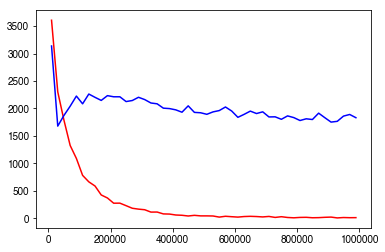

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure()
train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
y1, edges = np.histogram(train['dis'][train['label']>0], bins=50, range=(0,1000000), normed=False)
y2, edges = np.histogram(train['dis'][train['label']<=0], bins=50, range=(0,1000000), normed=False)
centers = (edges[1:] + edges[:-1])*0.5
plt.plot(centers, y1, color='r')
plt.plot(centers, y2, color='b')

In [15]:
colors = {
    'JEME': '#FF7F0E', 
    'JEME w/o global': '#FC6665',
    'JEME distance': '#FFBB78',
    'JEME w/o distance': '#FDCC65',
    'Common': '#073F80',
    'Common w/ distance w/o window features': '#00007F', 
    '4 types': '#0F7FFE',
    'Distance': '#66CCFE',
    'RIPPLE': "#2CA02C",
}


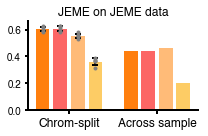

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
keys = ['JEME', 'JEME w/o global', 'JEME distance', 'JEME w/o distance']
chrom_split_data = {
    keys[0]: [0.6303988832,0.6168235665,0.5929405781,0.6070678711,0.5809326631],
    keys[1]: [0.6296804415,0.6241469946,0.5913012288,0.610447899,0.5840961292],
    keys[2]: [0.5553480207,0.5800307616,0.5329735872,0.5570833105,0.5512663922],
    keys[3]: [0.3738624171,0.367303917,0.385596147,0.3630977141,0.3154601546]
}
across_sample_data = {
    keys[0]:[0.443],
    keys[1]:[0.442],
    keys[2]: [0.460],
    keys[3]: [0.204]
}

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.bar(range(4), [np.mean(chrom_split_data[k]) for k in keys], yerr=[np.std(chrom_split_data[k]) for k in keys],
       capsize=3, color=[colors[k] for k in keys], error_kw={'capthick':2}, width=0.77)
ax.bar(range(5,9), [np.mean(across_sample_data[k]) for k in keys],
       capsize=3, color=[colors[k] for k in keys])
for i in range(4):
    ax.plot([i]*5, chrom_split_data[keys[i]], 'o',color='gray', markersize=3 )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_xticks([1.5,6.5])
ax.set_xticklabels(['Chrom-split','Across sample'],fontsize=12)
ax.tick_params(width=2)
ax.set_title('JEME on JEME data')
fig.tight_layout()
fig.savefig('jeme_on_jeme.pdf')
fig.savefig('jeme_on_jeme.png', dpi=300)

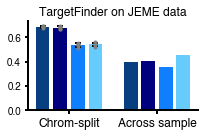

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
keys = ['Common', 'Common w/ distance w/o window features', 
        '4 types', 'Distance']
chrom_split_data = {
    keys[0]: [float(x) for x in '0.6979259114	0.6858154554	0.6836615023	0.6814514652	0.6983175299'.split()],
    keys[1]: [float(x) for x in '0.6972983606	0.6844361509	0.6665314246	0.6676582029	0.6843232293'.split()],
    keys[2]: [float(x) for x in '0.53437544	0.5451357867	0.5511251051	0.5095716733	0.5392235479'.split()],
    keys[3]: [float(x) for x in '0.5431282703	0.5607498935	0.5210186731	0.5444394055	0.5399434507'.split()]
}
across_sample_data = {
    keys[0]:[0.396],
    keys[1]:[0.401],
    keys[2]: [0.359],
    keys[3]: [0.458]
}

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.bar(range(4), [np.mean(chrom_split_data[k]) for k in keys], yerr=[np.std(chrom_split_data[k]) for k in keys],
       capsize=3, color=[colors[k] for k in keys], error_kw={'capthick':2}, width=0.77)
ax.bar(range(5,9), [np.mean(across_sample_data[k]) for k in keys],
       capsize=3, color=[colors[k] for k in keys])
for i in range(4):
    ax.plot([i]*5, chrom_split_data[keys[i]], 'o',color='gray', markersize=3 )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_xticks([1.5,6.5])
ax.set_xticklabels(['Chrom-split','Across sample'],fontsize=12)
ax.tick_params(width=2)
ax.set_title('TargetFinder on JEME data')
fig.tight_layout()
fig.savefig('targetfinder_on_jeme.pdf')
fig.savefig('targetfinder_on_jeme.png', dpi=300)

[0.6979259114, 0.6858154554, 0.6836615023, 0.6814514652, 0.6983175299]